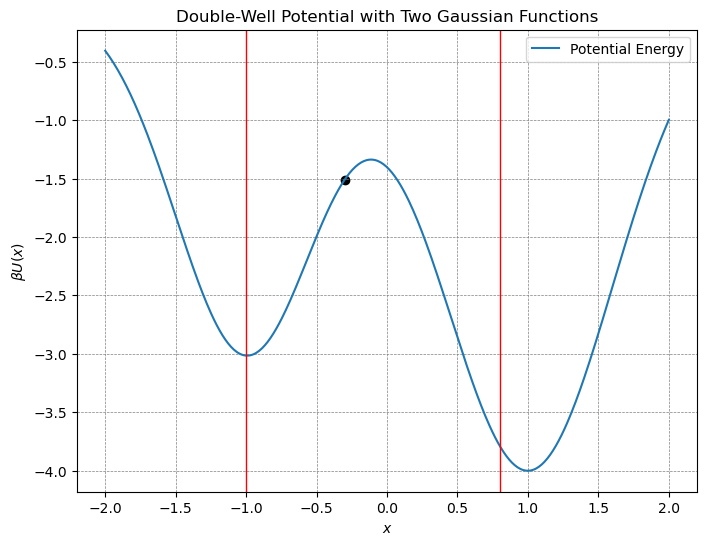

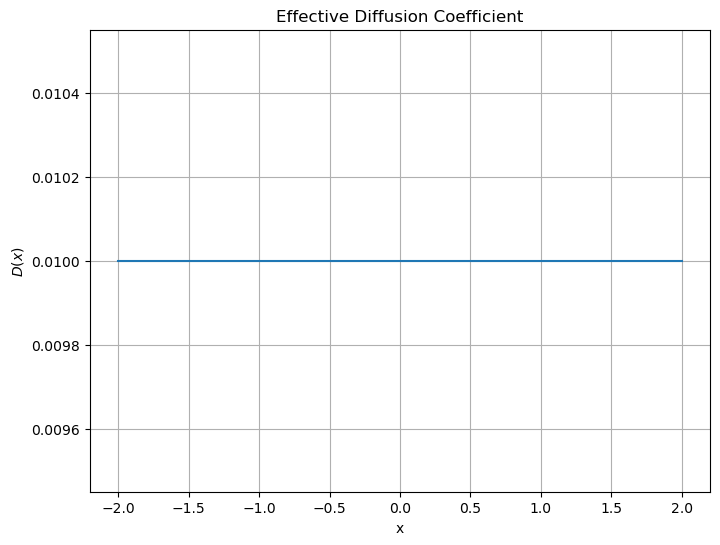

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
from scipy.integrate import quad
from scipy.interpolate import interp1d, PchipInterpolator

# Define the double-well potential using two Gaussian functions
def double_gaussian_potential(x, A1=3, mu1=-1, sigma1=0.5, A2=4, mu2=1, sigma2=0.6):
    V1 = A1 * np.exp(-((x - mu1)**2) / (2 * sigma1**2))
    V2 = A2 * np.exp(-((x - mu2)**2) / (2 * sigma2**2))
    return -(V1 + V2)
beta_U = double_gaussian_potential

D0 = 0.01
def D(x):
    # return D0*x**(2/3)
    return D0*x**0
x = np.linspace(-2, 2, 400)

# Plot the potential
plt.figure(figsize=(8, 6))
plt.plot(x, beta_U(x), label='Potential Energy')
plt.title('Double-Well Potential with Two Gaussian Functions')
plt.xlabel('$x$')
plt.ylabel(r'$\beta U(x)$')
# plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0.8, color='red',linewidth=1)
plt.axvline(-1.0, color='red',linewidth=1)
plt.scatter(-0.3, beta_U(-0.3), color='black')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(x, D(x))
plt.xlabel('x')
plt.ylabel("$D(x)$")
plt.title('Effective Diffusion Coefficient')
plt.grid(True)
plt.show()

In [16]:
a = -0.3  # location of Injecting point
b1 = -1.0   # location of lower absorbing boundary
b2 = 0.8   # location of upper absorbing boundary
h = 0.01
N = int((b2-b1)/h+1)
x_arr = np.linspace(b1, b2, N)
re_inject_idx = np.where(np.round(x_arr, decimals=10) == a)[0][0]

N1 = int((a-b1)/h+1)
N2 = int((b2-a)/h+1)
x1_arr = np.linspace(b1, a, N1)
x2_arr = np.linspace(a, b2, N2)

In [17]:
from transfer_matrix_recycle import TransferMatrix_AbInAb
from transfer_matrix_reptile import TransferMatrix_InReAb, TransferMatrix_AbReIn

aia_trans = TransferMatrix_AbInAb(h, x_arr, beta_U, recycle_idx=re_inject_idx, criteria=0)

ari1_trans = TransferMatrix_AbReIn(h, x1_arr, beta_U, 0)
ira2_trans = TransferMatrix_InReAb(h, x2_arr, beta_U, 0)

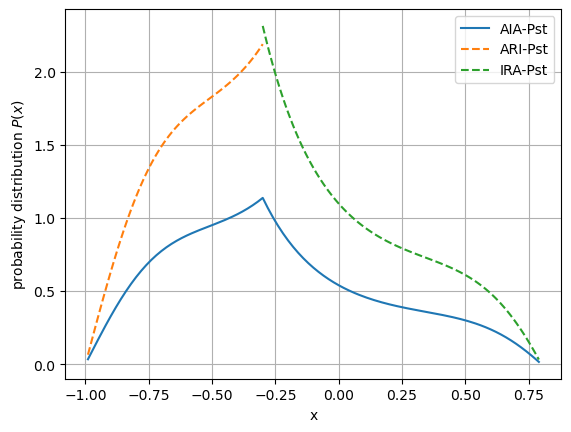

In [18]:
def get_steady_state(ria_trans):
    idx_fixed_vect = np.where(np.round(ria_trans.eig6_w.real, decimals=10) == 1)[0][0]
    steady_state = ria_trans.eig6_v[:,idx_fixed_vect].real/(h*np.sum(ria_trans.eig6_v[:,idx_fixed_vect].real))
    return steady_state

aia_trans.steady_state = get_steady_state(aia_trans)
ari1_trans.steady_state = get_steady_state(ari1_trans)
ira2_trans.steady_state = get_steady_state(ira2_trans)

plt.plot(x_arr[1:-1], aia_trans.steady_state, label="AIA-Pst")
plt.plot(x1_arr[1:], ari1_trans.steady_state, '--', label="ARI-Pst")
plt.plot(x2_arr[:-1], ira2_trans.steady_state, '--', label="IRA-Pst")

plt.xlabel('x')
plt.ylabel("probability distribution $P(x)$")
plt.legend()
plt.grid()

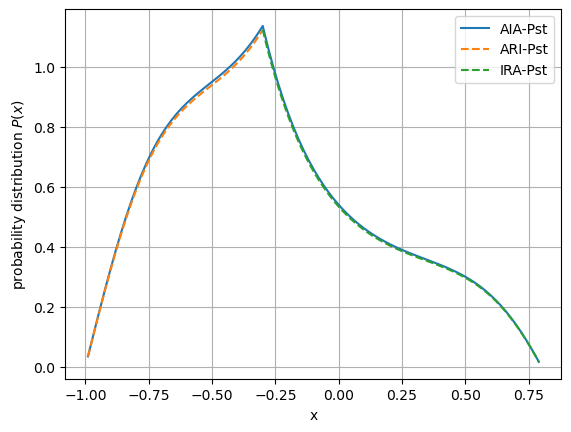

In [19]:
aa2 = ira2_trans.steady_state[0]
aa1 = ari1_trans.steady_state[-1]
aaa1 = aa2/(aa1+aa2)
aaa2 = aa1/(aa1+aa2)

plt.plot(x_arr[1:-1], aia_trans.steady_state, label="AIA-Pst")
plt.plot(x1_arr[1:], aaa1*ari1_trans.steady_state, '--', label="ARI-Pst")
plt.plot(x2_arr[:-1], aaa2*ira2_trans.steady_state, '--', label="IRA-Pst")

plt.xlabel('x')
plt.ylabel("probability distribution $P(x)$")
plt.legend()
plt.grid()

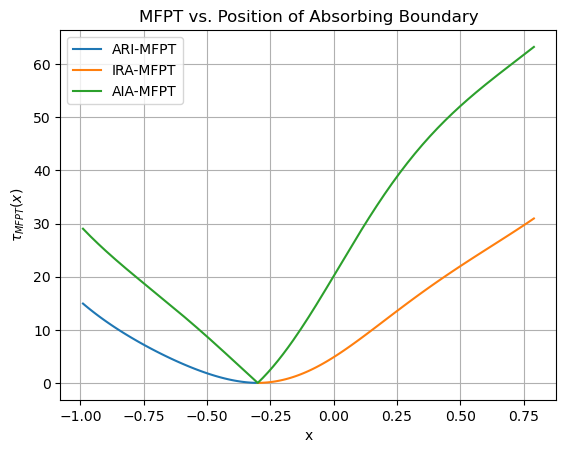

In [20]:
def mfpt_matrix(transMat_instance):
    ria_trans = transMat_instance
    ria_P = ria_trans.trans_mat.T
    idx_fixed_vect = np.where(np.round(ria_trans.eig6_w.real, decimals=10) == 1)[0][0]
    vec_pi = ria_trans.eig6_v[:,idx_fixed_vect].real/np.sum(ria_trans.eig6_v[:,idx_fixed_vect].real)
    N = vec_pi.size
    epsilon = np.ones(N)
    mat_I = np.eye(N)
    mat_E = np.ones((N, N))
    mat_Z = np.linalg.inv(mat_I-ria_P+np.outer(epsilon, vec_pi))
    vec_Zdg = np.diag(mat_Z)
    mat_Zdg = np.diag(vec_Zdg)
    mat_Mdg = np.diag(1/vec_pi)
    mat_M = (mat_I - mat_Z + mat_E @ mat_Zdg) @ mat_Mdg
    mat_Mbar = mat_M - mat_Mdg
    return mat_Mbar

m1_bar = mfpt_matrix(ari1_trans)
m2_bar = mfpt_matrix(ira2_trans)
m_merged_bar = mfpt_matrix(aia_trans)

delt_t = h**2/(2*D0)
plt.xlabel('x')
plt.ylabel(r"$\tau_{MFPT} (x)$")
# plt.plot(x_arr, mfpt_arr, '--')
plt.plot(x1_arr[1: ], delt_t*m1_bar[-1], label="ARI-MFPT")
plt.plot(x2_arr[:-1], delt_t*m2_bar[0], label="IRA-MFPT")
plt.plot(x_arr[1:-1], delt_t*m_merged_bar[re_inject_idx-1], label="AIA-MFPT")

plt.title('MFPT vs. Position of Absorbing Boundary')
plt.legend()
plt.grid()